# **Applied Data Science Capstone Project for IBM/Coursera**

### **The Battle of the Neighborhoods** (Canary Islands Edition)

## Introduction

The Canary Islands are a Spanish territory composed of a chain of volcanic islands located off the coast of Morocco in the Atlantic Ocean. The islands are a very popular holiday destination and arguably one of the best places to retire due to its great weather, excellent healthcare system and affordability among others.

This project explores and compares different characteristics of the different islands of the Canary Islands (Tenerife, Fuerteventura, Gran Canaria, Lanzarote, La Palma, La Gomera and El Hierro) from data obtained from several different sources with the goal of helping any current or future retirees who might be considering relocating to the Canary Islands determine the best location to relocate on the islands.

The project will generate a shortlist of promising suitable properties based on the following preferences or criteria: good climate (i.e. low rainfall, lots of sun, etc.), closeness to amenities and essential services (i.e. stores, entertainment and leisure options, pharmacies, etc.), and preferences regarding real estate (i.e. number of bathrooms, number of bedrooms, price, etc.). The retiree can then make use of the generated suggestions to make a more informed decision.

## Data

To solve the problem mentioned above, we will be analyzing and comparing data on weather, availability of amenities and essential services, as well as real estate listings in order to offer a recommendation of the best locations on Canary Islands.

Yearly weather data will be scraped from a common weather website (e.g. https://www.climatestotravel.com/) and the main focus will be on the following parameters:

- Average rainfall
- Average daily sunshine hours
- Average monthly minimum temperature
- Average monthly maximum temperature
- Average monthly sea temperature

The data on availability of amenities and essential services will be obtained through the FourSquare API.

Finally, real estate listings and prices will be scraped from a Spanish real estate website (e.g. https://www.tucasa.com/) and filtered based on a given set of requirements, such as:
- Maximum price
- Minimum number of bedrooms
- Minimum number of bathrooms
- Size
- etc.


## Methodology

#### Let's start by installing all required packages and libraries.

In [3]:
!pip install beautifulsoup4
!pip install lxml
!pip install geopandas
!pip install geopy
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re
import os

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported!')

     |████████████████████████████████| 122kB 20.9MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 6.5MB/s eta 0:00:01     |██████████████▍                 | 2.5MB 6.5MB/s eta 0:00:01
Libraries imported!


### 1. Determining the Island with the Best Climate

In order to determine which Island has the best climate, we first scrape yearly weather data from every island from the internet.

#### El Hierro

Let's obtain yearly weather data from El Hierro:

In [5]:
# Obtain information on climate of the island of El Hierro from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/el-hierro')

#Obtain data from all the tables
El_Hierro_ave_temp = table[1]
El_Hierro_ave_rainfall = table[2]
El_Hierro_ave_sunshine = table[3]
El_Hierro_ave_seatemp = table[4]

#Drop values in Fahrenheit and Inches
El_Hierro_ave_temp.drop([2, 3], inplace=True)
El_Hierro_ave_rainfall.drop([1], inplace=True)
El_Hierro_ave_seatemp.drop([1], inplace=True)
El_Hierro_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
El_Hierro_ave_temp.set_index('Month', inplace=True)
El_Hierro_ave_rainfall.set_index('Month', inplace=True)
El_Hierro_ave_sunshine.set_index('Month', inplace=True)
El_Hierro_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for El Hierro.

In [9]:
#First, we'll transpose all tables
EH_ave_T = El_Hierro_ave_temp.transpose()
EH_ave_Rain = El_Hierro_ave_rainfall.transpose()
EH_ave_Sun = El_Hierro_ave_sunshine.transpose()
EH_ave_SeaT = El_Hierro_ave_seatemp.transpose()

#Let's rename some columns for clarity
EH_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
EH_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
EH_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
EH_summary_table = pd.concat([EH_ave_T, EH_ave_Rain, EH_ave_Sun, EH_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
EH_summary_table['Island'] = 'El Hierro'
EH_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,17,21,28.0,3.0,5,20,El Hierro
Feb,16,21,38.0,3.0,6,19,El Hierro
Mar,17,21,25.0,3.0,6,19,El Hierro
Apr,17,22,13.0,2.0,7,19,El Hierro
May,18,23,2.0,1.0,8,20,El Hierro
Jun,19,24,1.0,0.0,8,21,El Hierro
Jul,21,25,0.0,0.0,7,22,El Hierro
Aug,21,26,1.0,0.0,8,23,El Hierro
Sep,22,27,3.0,1.0,7,24,El Hierro
Oct,21,26,14.0,3.0,6,23,El Hierro


### Fuerteventura

Let's obtain yearly weather data from Fuerteventura:

In [10]:
# Obtain information on climate of the island of Fuerteventura from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/fuerteventura')

#Obtain data from all the tables
Fuerteventura_ave_temp = table[1]
Fuerteventura_ave_rainfall = table[0]
Fuerteventura_ave_sunshine = table[2]
Fuerteventura_ave_seatemp = table[3]

#Drop values in Fahrenheit and Inches
Fuerteventura_ave_temp.drop([2, 3], inplace=True)
Fuerteventura_ave_rainfall.drop([1], inplace=True)
Fuerteventura_ave_seatemp.drop([1], inplace=True)
Fuerteventura_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
Fuerteventura_ave_temp.set_index('Month', inplace=True)
Fuerteventura_ave_rainfall.set_index('Month', inplace=True)
Fuerteventura_ave_sunshine.set_index('Month', inplace=True)
Fuerteventura_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for Fuerteventura.

In [11]:
#First, we'll transpose all tables
FV_ave_T = Fuerteventura_ave_temp.transpose()
FV_ave_Rain = Fuerteventura_ave_rainfall.transpose()
FV_ave_Sun = Fuerteventura_ave_sunshine.transpose()
FV_ave_SeaT = Fuerteventura_ave_seatemp.transpose()

#Let's rename some columns for clarity
FV_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
FV_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
FV_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
FV_summary_table = pd.concat([FV_ave_T, FV_ave_Rain, FV_ave_Sun, FV_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
FV_summary_table['Island'] = 'Fuerteventura'
FV_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,15,21,15.0,2.0,6,19,Fuerteventura
Feb,15,21,15.0,2.0,7,18,Fuerteventura
Mar,16,22,10.0,2.0,8,18,Fuerteventura
Apr,16,23,5.0,1.0,8,18,Fuerteventura
May,17,24,1.0,0.0,9,19,Fuerteventura
Jun,19,26,0.0,0.0,10,20,Fuerteventura
Jul,21,27,0.0,0.0,9,21,Fuerteventura
Aug,22,28,0.0,0.0,9,22,Fuerteventura
Sep,21,28,2.0,0.0,8,22,Fuerteventura
Oct,20,26,10.0,2.0,7,22,Fuerteventura


### Gran Canaria

Let's obtain yearly weather data from Gran Canaria:

In [12]:
# Obtain information on climate of the island of Gran Canaria from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/gran-canaria')

#Obtain data from all the tables
Gran_Canaria_ave_temp = table[0]
Gran_Canaria_ave_rainfall = table[1]
Gran_Canaria_ave_sunshine = table[2]
Gran_Canaria_ave_seatemp = table[3]

#Drop values in Fahrenheit and Inches
Gran_Canaria_ave_temp.drop([2, 3], inplace=True)
Gran_Canaria_ave_rainfall.drop([1], inplace=True)
Gran_Canaria_ave_seatemp.drop([1], inplace=True)
Gran_Canaria_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
Gran_Canaria_ave_temp.set_index('Month', inplace=True)
Gran_Canaria_ave_rainfall.set_index('Month', inplace=True)
Gran_Canaria_ave_sunshine.set_index('Month', inplace=True)
Gran_Canaria_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for Gran Canaria.

In [13]:
#First, we'll transpose all tables
GC_ave_T = Gran_Canaria_ave_temp.transpose()
GC_ave_Rain = Gran_Canaria_ave_rainfall.transpose()
GC_ave_Sun = Gran_Canaria_ave_sunshine.transpose()
GC_ave_SeaT = Gran_Canaria_ave_seatemp.transpose()

#Let's rename some columns for clarity
GC_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
GC_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
GC_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
GC_summary_table = pd.concat([GC_ave_T, GC_ave_Rain, GC_ave_Sun, GC_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
GC_summary_table['Island'] = 'Gran Canaria'
GC_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,15,21,25.0,3.0,6,19,Gran Canaria
Feb,15,21,25.0,3.0,7,19,Gran Canaria
Mar,16,22,10.0,2.0,7,19,Gran Canaria
Apr,16,23,6.0,1.0,8,19,Gran Canaria
May,17,24,1.0,0.0,9,20,Gran Canaria
Jun,19,25,0.0,0.0,9,21,Gran Canaria
Jul,21,27,0.0,0.0,10,22,Gran Canaria
Aug,22,28,0.0,0.0,10,22,Gran Canaria
Sep,21,27,9.0,1.0,8,23,Gran Canaria
Oct,20,26,15.0,2.0,7,23,Gran Canaria


### La Gomera

Let's obtain yearly weather data from La Gomera:

In [14]:
# Obtain information on climate of the island of La Gomera from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/la-gomera')

#Obtain data from all the tables
La_Gomera_ave_temp = table[0]
La_Gomera_ave_rainfall = table[1]
La_Gomera_ave_sunshine = table[2]
La_Gomera_ave_seatemp = table[3]

#Drop values in Fahrenheit and Inches
La_Gomera_ave_temp.drop([2, 3], inplace=True)
La_Gomera_ave_rainfall.drop([1], inplace=True)
La_Gomera_ave_seatemp.drop([1], inplace=True)
La_Gomera_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
La_Gomera_ave_temp.set_index('Month', inplace=True)
La_Gomera_ave_rainfall.set_index('Month', inplace=True)
La_Gomera_ave_sunshine.set_index('Month', inplace=True)
La_Gomera_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for La Gomera.

In [17]:
#First, we'll transpose all tables
LG_ave_T = La_Gomera_ave_temp.transpose()
LG_ave_Rain = La_Gomera_ave_rainfall.transpose()
LG_ave_Sun = La_Gomera_ave_sunshine.transpose()
LG_ave_SeaT = La_Gomera_ave_seatemp.transpose()

#Let's rename some columns for clarity
LG_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
LG_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
LG_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
LG_summary_table = pd.concat([LG_ave_T, LG_ave_Rain, LG_ave_Sun, LG_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
LG_summary_table['Island'] = 'La Gomera'
LG_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,16,21,60.0,6.0,6,19,La Gomera
Feb,15,21,50.0,6.0,7,19,La Gomera
Mar,16,21,40.0,6.0,7,19,La Gomera
Apr,16,22,25.0,5.0,8,19,La Gomera
May,17,23,8.0,3.0,9,20,La Gomera
Jun,19,24,4.0,2.0,9,21,La Gomera
Jul,21,26,1.0,1.0,10,22,La Gomera
Aug,21,26,2.0,1.0,10,23,La Gomera
Sep,21,27,11.0,3.0,8,23,La Gomera
Oct,20,26,40.0,5.0,7,23,La Gomera


### La Palma

Let's obtain yearly weather data from La Palma:

In [18]:
# Obtain information on climate of the island of La Palma from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/la-palma')

#Obtain data from all the tables
La_Palma_ave_temp = table[1]
La_Palma_ave_rainfall = table[0]
La_Palma_ave_sunshine = table[2]
La_Palma_ave_seatemp = table[4]

#Drop values in Fahrenheit and Inches
La_Palma_ave_temp.drop([2, 3], inplace=True)
La_Palma_ave_rainfall.drop([1], inplace=True)
La_Palma_ave_seatemp.drop([1], inplace=True)
La_Palma_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
La_Palma_ave_temp.set_index('Month', inplace=True)
La_Palma_ave_rainfall.set_index('Month', inplace=True)
La_Palma_ave_sunshine.set_index('Month', inplace=True)
La_Palma_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for La Palma.

In [19]:
#First, we'll transpose all tables
LP_ave_T = La_Palma_ave_temp.transpose()
LP_ave_Rain = La_Palma_ave_rainfall.transpose()
LP_ave_Sun = La_Palma_ave_sunshine.transpose()
LP_ave_SeaT = La_Palma_ave_seatemp.transpose()

#Let's rename some columns for clarity
LP_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
LP_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
LP_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
LP_summary_table = pd.concat([LP_ave_T, LP_ave_Rain, LP_ave_Sun, LP_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
LP_summary_table['Island'] = 'La Palma'
LP_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,16,21,50.0,5.0,6,20,La Palma
Feb,15,21,55.0,4.0,7,19,La Palma
Mar,16,21,35.0,4.0,7,19,La Palma
Apr,16,22,20.0,3.0,8,19,La Palma
May,17,23,7.0,1.0,9,20,La Palma
Jun,19,24,2.0,0.0,9,21,La Palma
Jul,21,26,1.0,0.0,10,22,La Palma
Aug,21,26,1.0,0.0,10,23,La Palma
Sep,21,27,12.0,2.0,8,24,La Palma
Oct,20,26,40.0,5.0,7,23,La Palma


### Lanzarote

Let's obtain yearly weather data from Lanzarote:

In [20]:
# Obtain information on climate of the island of Lanzarote from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/lanzarote')

#Obtain data from all the tables
Lanzarote_ave_temp = table[1]
Lanzarote_ave_rainfall = table[0]
Lanzarote_ave_sunshine = table[2]
Lanzarote_ave_seatemp = table[3]

#Drop values in Fahrenheit and Inches
Lanzarote_ave_temp.drop([2, 3], inplace=True)
Lanzarote_ave_rainfall.drop([1], inplace=True)
Lanzarote_ave_seatemp.drop([1], inplace=True)
Lanzarote_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
Lanzarote_ave_temp.set_index('Month', inplace=True)
Lanzarote_ave_rainfall.set_index('Month', inplace=True)
Lanzarote_ave_sunshine.set_index('Month', inplace=True)
Lanzarote_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for Lanzarote.

In [21]:
#First, we'll transpose all tables
LZ_ave_T = Lanzarote_ave_temp.transpose()
LZ_ave_Rain = Lanzarote_ave_rainfall.transpose()
LZ_ave_Sun = Lanzarote_ave_sunshine.transpose()
LZ_ave_SeaT = Lanzarote_ave_seatemp.transpose()

#Let's rename some columns for clarity
LZ_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
LZ_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
LZ_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
LZ_summary_table = pd.concat([LZ_ave_T, LZ_ave_Rain, LZ_ave_Sun, LZ_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
LZ_summary_table['Island'] = 'Lanzarote'
LZ_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,14,21,15.0,3.0,7,19,Lanzarote
Feb,14,21,20.0,3.0,7,18,Lanzarote
Mar,15,23,10.0,2.0,8,18,Lanzarote
Apr,16,24,5.0,1.0,8,18,Lanzarote
May,17,25,2.0,0.0,10,19,Lanzarote
Jun,19,26,0.0,0.0,10,20,Lanzarote
Jul,20,28,0.0,0.0,10,21,Lanzarote
Aug,21,29,0.0,0.0,10,22,Lanzarote
Sep,21,29,2.0,0.0,8,22,Lanzarote
Oct,19,27,10.0,2.0,8,22,Lanzarote


### Tenerife

Let's obtain yearly weather data from Tenerife:

In [22]:
# Obtain information on climate of the island of Tenerife (Southern part) from a popular travel weather website
table = pd.read_html('https://www.climatestotravel.com/climate/canary-islands/tenerife')

#Obtain data from all the tables
Tenerife_ave_temp = table[2]
Tenerife_ave_rainfall = table[3]
Tenerife_ave_sunshine = table[4]
Tenerife_ave_seatemp = table[5]

#Drop values in Fahrenheit and Inches
Tenerife_ave_temp.drop([2, 3], inplace=True)
Tenerife_ave_rainfall.drop([1], inplace=True)
Tenerife_ave_seatemp.drop([1], inplace=True)
Tenerife_ave_rainfall.drop(columns=['Year'], inplace=True)

#Set first column as index
Tenerife_ave_temp.set_index('Month', inplace=True)
Tenerife_ave_rainfall.set_index('Month', inplace=True)
Tenerife_ave_sunshine.set_index('Month', inplace=True)
Tenerife_ave_seatemp.set_index('Month', inplace=True)

Now let's build a summary table with all values for Tenerife.

In [23]:
#First, we'll transpose all tables
TF_ave_T = Tenerife_ave_temp.transpose()
TF_ave_Rain = Tenerife_ave_rainfall.transpose()
TF_ave_Sun = Tenerife_ave_sunshine.transpose()
TF_ave_SeaT = Tenerife_ave_seatemp.transpose()

#Let's rename some columns for clarity
TF_ave_Rain.rename({'Days': 'Rainy Days'}, axis=1, inplace=True)
TF_ave_Sun.rename({'Hours': 'Hours of Sun'}, axis=1, inplace=True)
TF_ave_SeaT.rename({'Temp (°C)': 'Sea Temp (°C)'}, axis=1, inplace=True)

#Now, we'll combine all data into one single table
TF_summary_table = pd.concat([TF_ave_T, TF_ave_Rain, TF_ave_Sun, TF_ave_SeaT], axis=1)

#Finally, we'll add a new column to identify the values to the island
TF_summary_table['Island'] = 'Tenerife'
TF_summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,15,22,15.0,2.0,6,19,Tenerife
Feb,15,22,20.0,2.0,7,19,Tenerife
Mar,16,23,15.0,2.0,7,19,Tenerife
Apr,16,23,7.0,1.0,7,19,Tenerife
May,17,24,1.0,0.0,8,20,Tenerife
Jun,19,25,0.0,0.0,9,21,Tenerife
Jul,20,28,0.0,0.0,10,22,Tenerife
Aug,21,28,1.0,0.0,9,23,Tenerife
Sep,21,28,4.0,1.0,7,23,Tenerife
Oct,20,27,12.0,2.0,7,23,Tenerife


### All Islands

We can now combine all tables into one big, overall summary table:

In [24]:
summary_table = pd.concat([EH_summary_table, FV_summary_table, GC_summary_table, LG_summary_table, 
                           LP_summary_table, LZ_summary_table, TF_summary_table], axis=0)
summary_table

Month,Min (°C),Max (°C),Prec.(mm),Rainy Days,Hours of Sun,Sea Temp (°C),Island
Jan,17,21,28.0,3.0,5,20,El Hierro
Feb,16,21,38.0,3.0,6,19,El Hierro
Mar,17,21,25.0,3.0,6,19,El Hierro
Apr,17,22,13.0,2.0,7,19,El Hierro
May,18,23,2.0,1.0,8,20,El Hierro
...,...,...,...,...,...,...,...
Aug,21,28,1.0,0.0,9,23,Tenerife
Sep,21,28,4.0,1.0,7,23,Tenerife
Oct,20,27,12.0,2.0,7,23,Tenerife
Nov,18,25,25.0,2.0,6,22,Tenerife


Let's use box plots from the Seaborn Library to visualize the data and see how the islands compare to each other.

First, we plot the yearly temperatures:

[Text(0, 0, 'El Hierro'),
 Text(0, 0, 'Fuerteventura'),
 Text(0, 0, 'Gran Canaria'),
 Text(0, 0, 'La Gomera'),
 Text(0, 0, 'La Palma'),
 Text(0, 0, 'Lanzarote'),
 Text(0, 0, 'Tenerife')]

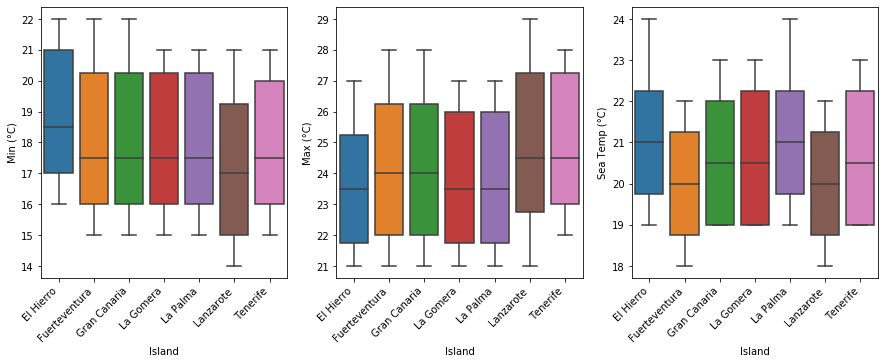

In [25]:
fig, ax =plt.subplots(1,3, figsize=(15,5))
sns.boxplot(x='Island', y='Min (°C)', data=summary_table, ax=ax[0])
sns.boxplot(x='Island', y='Max (°C)', data=summary_table, ax=ax[1])
sns.boxplot(x='Island', y='Sea Temp (°C)', data=summary_table, ax=ax[2])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")
ax[2].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")

Now, we plot the data regarding rainfall and sunshine:

[Text(0, 0, 'El Hierro'),
 Text(0, 0, 'Fuerteventura'),
 Text(0, 0, 'Gran Canaria'),
 Text(0, 0, 'La Gomera'),
 Text(0, 0, 'La Palma'),
 Text(0, 0, 'Lanzarote'),
 Text(0, 0, 'Tenerife')]

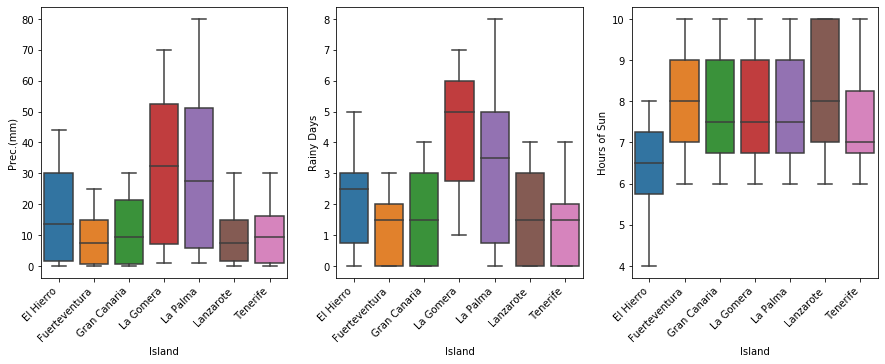

In [26]:
fig, ax =plt.subplots(1,3, figsize=(15,5))
sns.boxplot(x='Island', y='Prec.(mm)', data=summary_table, ax=ax[0])
sns.boxplot(x='Island', y='Rainy Days', data=summary_table, ax=ax[1])
sns.boxplot(x='Island', y='Hours of Sun', data=summary_table, ax=ax[2])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")
ax[2].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")

From the temperature plots, we can see that all islands have very similar temperatures ranges, with *Lanzarote* having a slightly colder winter and a warmer summer, as well as lower sea temperatures. On the other side of the scale, we have *El Hierro*, which has a warmer winter, a not too warm summer and higher sea temperatures. But, as already stated, the difference is not very significant.

The rainfall and sunshine plots, however, offer us a much clearer picture. We can clearly see, for example, that *El Hierro* has the least amount of sunshine hours per day. We can also see that *Fuerteventura, Lanzarote and Tenerife* have the least amount of rainfall, with *Fuerteventura* having the least amount of rainy days per month.

All in all, **Fuerteventura** has a slight edge over the other islands, making it the "photo-finish" winner of the "Battle of the Islands".

## 2. The Real Estate Market in Fuerteventura

The next step is to have a look at the real estate market in Fuerteventura.

We'll first start by scraping the relevant data for property listings in the island from a popular Spanish real estate website.

In [27]:
#extraction of relevant data for property listings in Fuerteventura
listing_found = True
page_num = 1
listings = []
progress = 'Progress: '
print(progress, end = '')

while listing_found and page_num <51: # page number limitation to limit search to max. 1000 listings
    
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    
    # set url 
    url = 'https://www.tucasa.com/compra-venta/viviendas/fuerteventura/?r=&idz=0035.0002&ord=&pgn={}'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all containers of listings
    properties_containers = soup.find_all('div', class_="divisor-tipo-listado col-xs-12")
    
    # check if page contains listings
    if len(properties_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for prop in properties_containers:
        try:
            info = prop.find_all('div', class_="contenedor-descripcion-inmueble")[0]

            try:
                size = info.find_all('li', class_="metros-cuadrados")[0].text.split(" ")[0]
            except:
                size = np.nan

            try:
                rooms = info.find_all('li', class_="num-habitaciones visible-xs visible-sm")[0].text.split(" ")[0]
            except:
                rooms = np.nan
                
            try:
                baths = info.find_all('li', class_="num-baños")[0].text.split(" ")[0]
            except:
                baths = np.nan

            try:
                location = prop.find_all('span', class_="titulo-inmueble")[0].text.split(",")[0]
                location = location.replace('\n', '')
                location = location.replace('\r', '')
                location = location.replace('\t', '')
            except:
                location = np.nan
                
            try:
                street = prop.find_all('span', class_="calle-inmueble")[0].text.split(",")[0]
            except:
                street = np.nan
            
            try:
                price = info.find_all('span', class_="precio-card")[0].text.split()[0]
            except:
                price = np.nan
                    

        except:
            size, rooms, baths, street, price, location = np.nan

        listings.append([location, street, size, rooms, baths, price])
    
    # increase page number
    page_num += 1
    
    # add progress to progress bar
    print('.', end = '')
    
    # set sleep to mimic a more human behaviour to avoid overloading the site with requests
    sleep(np.random.randint(1,3))
    
print(' 100%' + os.linesep + 'Scraping of properties for sale done!')

Progress: .................................................. 100%
Scraping of properties for sale done!


Then, we build a dataframe from the scraped data and name the dataframe's columns:

In [28]:
column_names = ['Location', 'Street', 'Size', 'Rooms', 'Bathrooms', 'Price']
properties = pd.DataFrame(listings, columns=column_names)

Let's see how many properties we have in total and how the dataframe looks like.

In [29]:
print('There are {} properties in the dataset'.format(properties.shape[0]))
properties.head(10)

There are 1000 properties in the dataset


,Location,Street,Size,Rooms,Bathrooms,Price
0,Puerto del Rosario,CANDRAY 10,125,3,2,165.000
1,Corralejo,,50,2,1,29.900
2,Antigua,,1000,3,3,275.000
3,Corralejo,,53,1,1,115.900
4,Tuineje,,170,4,2,368.000
5,Puerto del Rosario,VIRGEN DE LA PEÑA,78,3,1,66.000
6,Antigua,,150,5,2,147.500
7,Puerto del Rosario,Calle PITERA,96,3,2,82.800
8,Antigua,,135,NaN,NaN,95.000
9,Puerto del Rosario,,118,3,2,212.000


Let's also see what types we have in the dataframe:

In [30]:
properties.dtypes

Location     object
Street       object
Size         object
Rooms        object
Bathrooms    object
Price        object
dtype: object

### Data Pre-processing and Cleaning

Let's clean up the data by eliminating rows with empty data or duplicate listings, modifying types for some columns and finally reseting the indexes.

In [31]:
#clean up data a little bit and modify the type for some columns
properties['Size'] = properties['Size'].str.replace('sin', 'NaN').astype('float')
properties['Rooms'] = properties['Rooms'].astype('float')
properties['Bathrooms'] = properties['Bathrooms'].astype('float')
properties.loc[properties['Price'].str.contains('sin'), 'Price'] = '0'
properties['Price'] = properties['Price'].str.replace('.', '').astype('int')
properties['Price'] = properties['Price'].astype('int')

#drop rows with empty data (except for Street)
properties.dropna(subset=['Location', 'Size', 'Rooms', 'Bathrooms', 'Price'], inplace=True)
properties = properties[properties.Price != '0']

#drop duplicate properties
properties.drop_duplicates(inplace=True)

#reset indexes
properties.reset_index(drop=True, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


We can additionally calculate the price per square meter and add it to the table:

In [32]:
#calculate the price per square meter
properties['Price/m2'] = (properties['Price']/properties['Size']).round(2)

Let's see how the dataframe looks like now:

In [33]:
properties.head(10)

,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2
0,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00
1,Corralejo,,50.0,2.0,1.0,29900,598.00
2,Antigua,,1000.0,3.0,3.0,275000,275.00
3,Corralejo,,53.0,1.0,1.0,115900,2186.79
4,Tuineje,,170.0,4.0,2.0,368000,2164.71
5,Puerto del Rosario,VIRGEN DE LA PEÑA,78.0,3.0,1.0,66000,846.15
6,Antigua,,150.0,5.0,2.0,147500,983.33
7,Puerto del Rosario,Calle PITERA,96.0,3.0,2.0,82800,862.50
8,Puerto del Rosario,,118.0,3.0,2.0,212000,1796.61
9,Puerto del Rosario,,125.0,3.0,1.0,165000,1320.00


Let's get an initial statistical idea of what our dataframe contains:

In [34]:
properties.describe()

,Size,Rooms,Bathrooms,Price,Price/m2
count,863.000000,863.000000,863.000000,8.630000e+02,863.000000
mean,114.393975,2.534183,1.667439,2.002121e+05,1888.614276
std,137.995746,1.198772,0.894398,1.791617e+05,941.880430
min,27.000000,1.000000,1.000000,0.000000e+00,0.000000
25%,62.000000,2.000000,1.000000,9.900000e+04,1250.000000
50%,87.000000,2.000000,1.000000,1.400000e+05,1740.000000
75%,125.000000,3.000000,2.000000,2.270000e+05,2256.390000
max,3300.000000,10.000000,8.000000,1.600000e+06,12121.210000


Now, let's visualize the data to get a better idea of what we're dealing with:

[Text(0, 0, 'Puerto del Rosario'),
 Text(0, 0, 'Corralejo'),
 Text(0, 0, 'Antigua'),
 Text(0, 0, 'Tuineje'),
 Text(0, 0, 'Caleta de Fuste'),
 Text(0, 0, 'Gran Tarajal'),
 Text(0, 0, 'La Oliva '),
 Text(0, 0, 'Costa Calma'),
 Text(0, 0, 'Altea'),
 Text(0, 0, 'Pajara'),
 Text(0, 0, 'El Cotillo'),
 Text(0, 0, 'Lajares'),
 Text(0, 0, 'Morro del Jable'),
 Text(0, 0, 'Costa de Antigua'),
 Text(0, 0, 'Parque Holandés')]

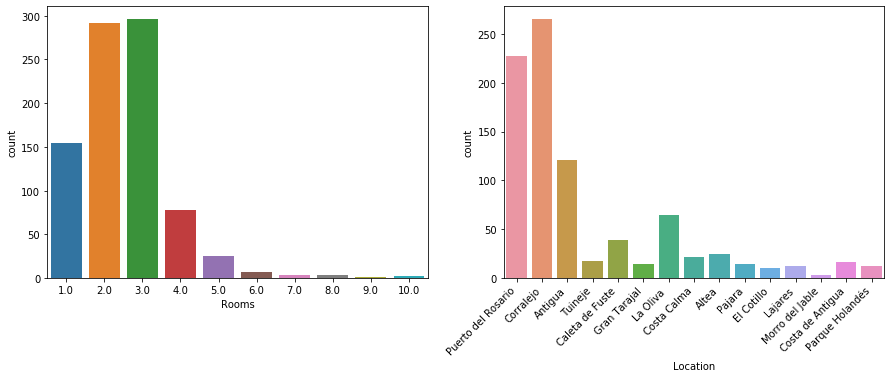

In [35]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.countplot(properties['Rooms'], ax=ax[0])
sns.countplot(properties['Location'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")

Let's see if there is a correlation between price and size of the property:

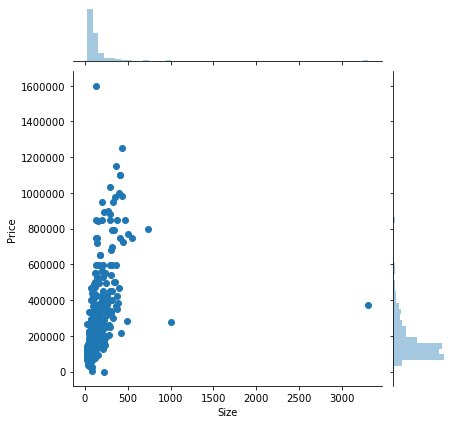

In [36]:
sns.jointplot(x='Size', y='Price', data=properties[['Size','Price']])

Let's try that again, this time removing any possible outliers by limiting the range.

In [37]:
#remove possible outliers
properties = properties[properties['Size'] <= 800]
properties = properties[properties['Price'] > 1000]

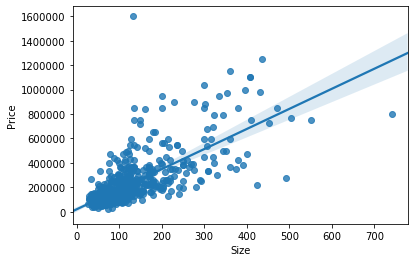

In [38]:
sns.regplot(x='Size', y='Price', data=properties[['Size','Price']]);

Now let's see the distribution of the data using box plots from the Seaborn Library to get an idea of how the number of rooms and bathrooms affects price and price per square meter:

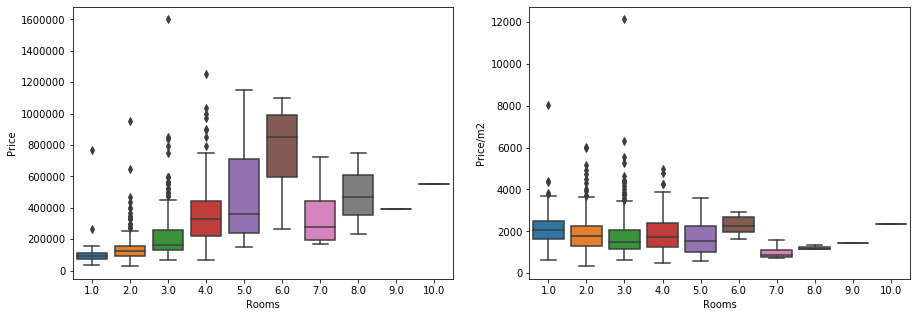

In [39]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.boxplot(x='Rooms', y='Price', data=properties, ax=ax[0])
sns.boxplot(x='Rooms', y='Price/m2', data=properties, ax=ax[1])

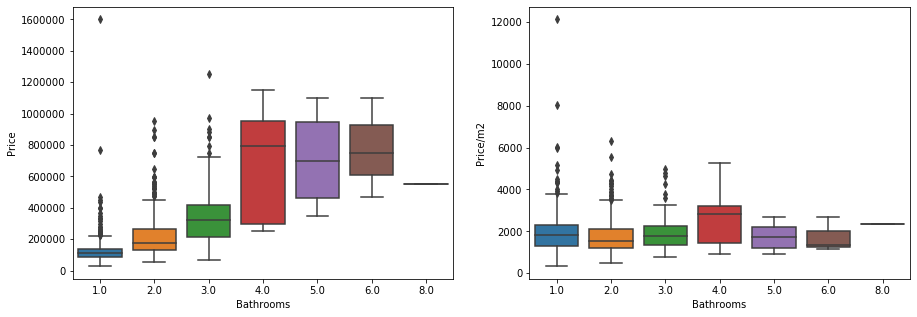

In [40]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.boxplot(x='Bathrooms', y='Price', data=properties, ax=ax[0])
sns.boxplot(x='Bathrooms', y='Price/m2', data=properties, ax=ax[1])

The data indicates that the number of rooms and bathrooms appear to have an influence on the ovarall price of the property up to 6 rooms and up to 4 bathrooms respectively, but not necessarily on the price per square meter.

Let's see now if the location on the island has an influence as well:

[Text(0, 0, 'Puerto del Rosario'),
 Text(0, 0, 'Corralejo'),
 Text(0, 0, 'Tuineje'),
 Text(0, 0, 'Antigua'),
 Text(0, 0, 'Caleta de Fuste'),
 Text(0, 0, 'Gran Tarajal'),
 Text(0, 0, 'La Oliva '),
 Text(0, 0, 'Costa Calma'),
 Text(0, 0, 'Altea'),
 Text(0, 0, 'Pajara'),
 Text(0, 0, 'El Cotillo'),
 Text(0, 0, 'Lajares'),
 Text(0, 0, 'Morro del Jable'),
 Text(0, 0, 'Costa de Antigua'),
 Text(0, 0, 'Parque Holandés')]

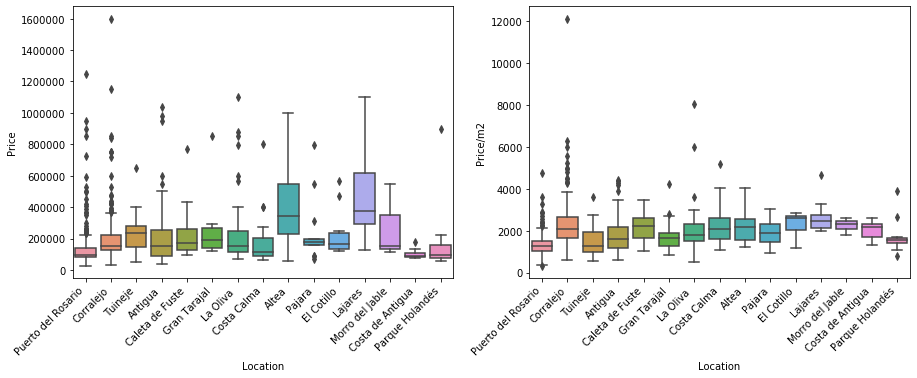

In [41]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.boxplot(x='Location', y='Price', data=properties, ax=ax[0])
sns.boxplot(x='Location', y='Price/m2', data=properties, ax=ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")
#ax.tick_params(labelsize=10)

The data appears to show that the properties in *Altea* and *Lajares* have consecuently higher-priced units, with *Puerto del Rosario* and *Corralejo*, in particular, having lots of outliers. So, in general, location by itself seems to have no significant influence on price and price per square meter.

Let's save the dataframe as a csv file for reference:

In [42]:
#saving dataframe as csv
properties.to_csv('Property_Listings_Fuerteventura.csv', index=False, encoding='utf-8-sig')

### Obtaining a Preliminary Shortlist of Promising Suitable Properties

Let's limit the properties based on preferences. Let's say we have a maximum budget of 180,000 EUR and want to have a property that has at least 3 rooms, 2 bathrooms and is at least 120 square meters in size:

In [69]:
#limit the list of properties based on preferences (i.e. number of rooms, number of bathrooms, price, price/m2, etc.)
properties_shortlist = properties.drop(properties.loc[properties['Rooms']<3].index)
properties_shortlist.drop(properties_shortlist.loc[properties_shortlist['Bathrooms']<2].index, inplace=True)
properties_shortlist.drop(properties_shortlist.loc[properties_shortlist['Price']>180000].index, inplace=True)
properties_shortlist.drop(properties_shortlist.loc[properties_shortlist['Size']<120].index, inplace=True)
#properties_shortlist.drop(properties_shortlist.loc[properties_shortlist['Price/m2']>1100].index, inplace=True)

#reset indexes
properties_shortlist.reset_index(drop=True, inplace=True)
properties_shortlist.shape

(40, 7)

Let now add latitude and longitude columns to the dataframe and initialize the values to 0:

In [70]:
# adding latitude and longitude columns and initiating them as floats
property_locations = properties_shortlist
property_locations['Latitude'] = 0.0
property_locations['Longitude'] = 0.0

In order to analyze locations, we need a valid address, so we'll drop all rows that have no address and then we'll add unique IDs to each property.

In [71]:
# drop rows rows with no value for "Street"
property_locations['Street'].replace('', np.nan, inplace=True)
property_locations.dropna(subset=['Street'], inplace=True)

# reset indexes
property_locations.reset_index(drop=True, inplace=True)

# add Location IDs
property_locations.insert(0, column='ID', value=property_locations.index + 1)
property_locations['ID'] = property_locations['ID'].astype('str')

print("The property shortlist has " + str(len(property_locations)) + " properties in total")

property_locations.head()

The property shortlist has 20 properties in total


,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2,Latitude,Longitude
0,1,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00,0.0,0.0
1,2,Gran Tarajal,Calle MAJUGA,122.0,3.0,3.0,165000,1352.46,0.0,0.0
2,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,126.0,3.0,2.0,155000,1230.16,0.0,0.0
3,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,150000,1162.79,0.0,0.0
4,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,124.0,3.0,2.0,150000,1209.68,0.0,0.0


Let's now find the latitudes and longitutes of each property listing of the shortlist:

In [72]:
# finding latitude and longitude for each listing
geolocator = Nominatim(user_agent="canary-islands-locator")

# print progess bar
progress = 'Progress: '
print(progress, end = '')

for i in range(len(property_locations)) :
    address = property_locations.iloc[i]['Street'] + ', ' + property_locations.iloc[i]['Location'] 
    location = geolocator.geocode(address)
    if not location:
        address = 'calle ' + property_locations.iloc[i]['Street'] + ', ' + property_locations.iloc[i]['Location']
        location = geolocator.geocode(address)
        if not location:
            address = property_locations.iloc[i]['Location'] + ', España'
            location = geolocator.geocode(address)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        property_locations.at[i, "Latitude"] = latitude
        property_locations.at[i, "Longitude"] = longitude
        
    # add progress to progress bar
    print('.', end = '')
    
print(' 100%' + os.linesep + 'Fetching of geolocations done!')
property_locations.head()

Progress: .................... 100%
Fetching of geolocations done!


,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2,Latitude,Longitude
0,1,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00,28.499342,-13.859905
1,2,Gran Tarajal,Calle MAJUGA,122.0,3.0,3.0,165000,1352.46,28.210684,-14.030876
2,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,126.0,3.0,2.0,155000,1230.16,28.730723,-13.865191
3,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,150000,1162.79,28.730723,-13.865191
4,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,124.0,3.0,2.0,150000,1209.68,28.730723,-13.865191


Let's have a look at the statistical distribution of the data in the shortlist:

In [73]:
property_locations.describe()

,Size,Rooms,Bathrooms,Price,Price/m2,Latitude,Longitude
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,131.350000,3.100000,2.150000,147970.150000,1134.568500,28.594489,-13.900832
std,17.193251,0.307794,0.366348,15696.487687,119.816226,0.177319,0.074885
min,120.000000,3.000000,2.000000,125500.000000,930.830000,28.210684,-14.110690
25%,120.000000,3.000000,2.000000,133375.000000,1061.220000,28.408097,-13.875721
50%,123.000000,3.000000,2.000000,150000.000000,1119.035000,28.727794,-13.865191
75%,131.750000,3.000000,2.000000,162750.000000,1214.800000,28.730723,-13.865191
max,174.000000,4.000000,3.000000,169000.000000,1352.460000,28.730723,-13.856528


Let's create a map using Folium to see where all properties are located on the island:

In [74]:
# create map of Fuerteventura using latitude and longitude values
map_fuerteventura = folium.Map(location=[28.3333, -14.0167], zoom_start=9)

# add property listings as markers to map
for lat, lng, price, rooms, baths in zip(property_locations['Latitude'], property_locations['Longitude'], property_locations['Price'],
                                        property_locations['Rooms'],  property_locations['Bathrooms']):
    label = '{} EUR, {} Rooms, {} Baths'.format(price, rooms, baths)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fuerteventura)    
map_fuerteventura

### Examining Ammenities Nearby Using the FourSquare API

Definition of FourSquare Credentials and Version:

In [229]:
# @hidden_cell
CLIENT_ID = 'CGGE2ASDGX5KP54LNQATD0AXUYU5J1AIRYPSCUE2BAWQSTQX' # your Foursquare ID
CLIENT_SECRET = 'EEU3UQRXWLSS3HCFKUWAFRQLEWM4XASF4SXHSX2TYMSCRNMM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's create a function to repeat the same process for all property listings in the shortlist. The function will look for all venues within a radius of 500 m for each property:

In [232]:
def getNearbyVenues(ID, streets, locations, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list=[]
    for ID, street, location, lat, lng in zip(ID, streets, locations, latitudes, longitudes):    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ID,
            street,
            location,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ID',
                  'Street',
                  'Location', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

Now, let's run the function:

In [233]:
locations_venues = getNearbyVenues(ID=property_locations['ID'],
                                   streets=property_locations['Street'],
                                   locations=property_locations['Location'],
                                   latitudes=property_locations['Latitude'],
                                   longitudes=property_locations['Longitude']
                                  )
print('Data acquisition complete!')

Data acquisition complete!


Let's see how the obtained data looks like:

In [234]:
print(locations_venues.shape)
locations_venues.head()

(241, 9)


,ID,Street,Location,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,CANDRAY 10,Puerto del Rosario,28.499342,-13.859905,Bar Terraza Los Paraguitas,28.498085,-13.858829,Tapas Restaurant
1,1,CANDRAY 10,Puerto del Rosario,28.499342,-13.859905,Cafeteria Son Son,28.500108,-13.863545,Café
2,1,CANDRAY 10,Puerto del Rosario,28.499342,-13.859905,Casa Toño,28.497128,-13.860780,Gastropub
3,1,CANDRAY 10,Puerto del Rosario,28.499342,-13.859905,La Saranda,28.497784,-13.860796,Breakfast Spot
4,1,CANDRAY 10,Puerto del Rosario,28.499342,-13.859905,Ciao Mare,28.495938,-13.860893,Pizza Place


Let's group the data according to property ID and count how many venues are nearby each property:

In [235]:
locations_venues.groupby('ID').count()

,Street,Location,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ID,,,,,,,,
1,10,10,10,10,10,10,10,10
10,18,18,18,18,18,18,18,18
11,18,18,18,18,18,18,18,18
12,5,5,5,5,5,5,5,5
13,1,1,1,1,1,1,1,1
14,4,4,4,4,4,4,4,4
15,10,10,10,10,10,10,10,10
16,1,1,1,1,1,1,1,1
17,18,18,18,18,18,18,18,18


Let's find out how many unique categories we have from all the returned venues:

In [236]:
print('There are {} uniques categories.'.format(len(locations_venues['Venue Category'].unique())))

There are 36 uniques categories.


#### Now, let's analyze each location more in detail:

First, we'll use one hot encoding and add ID and Street columns back to the dataframe:

In [237]:
# one hot encoding
locations_onehot = pd.get_dummies(locations_venues[['Venue Category']], prefix="", prefix_sep="")

# add ID and Street columns back to dataframe
locations_onehot['ID'] = locations_venues['ID']
locations_onehot['Street'] = locations_venues['Street'] + ', ' + locations_venues['Location']

# move street column to the first column and then ID
fixed_columns = [locations_onehot.columns[-1]] + list(locations_onehot.columns[:-1])
locations_onehot = locations_onehot[fixed_columns]
fixed_columns = [locations_onehot.columns[-1]] + list(locations_onehot.columns[:-1])
locations_onehot = locations_onehot[fixed_columns]

locations_onehot.head()

,ID,Street,Athletics & Sports,Bar,Beach,Bed & Breakfast,Bistro,Board Shop,Breakfast Spot,Burger Joint,...,Plaza,Resort,Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Supermarket,Tapas Restaurant,Water Park
0,1,"CANDRAY 10, Puerto del Rosario",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,"CANDRAY 10, Puerto del Rosario",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"CANDRAY 10, Puerto del Rosario",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,"CANDRAY 10, Puerto del Rosario",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,"CANDRAY 10, Puerto del Rosario",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we'll group rows by ID and Street (incl. Location) and take the mean of the frequency of occurrence of each category:

In [238]:
locations_grouped = locations_onehot.groupby(['ID', 'Street']).mean().reset_index()
locations_grouped

,ID,Street,Athletics & Sports,Bar,Beach,Bed & Breakfast,Bistro,Board Shop,Breakfast Spot,Burger Joint,...,Plaza,Resort,Restaurant,Shopping Mall,Snack Place,Spa,Spanish Restaurant,Supermarket,Tapas Restaurant,Water Park
0,1,"CANDRAY 10, Puerto del Rosario",0.000000,0.000000,0.000000,0.00,0.100000,0.0,0.1,0.00,...,0.00,0.000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.2,0.00
1,10,"Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Co...",0.055556,0.055556,0.111111,0.00,0.055556,0.0,0.0,0.00,...,0.00,0.000,0.055556,0.055556,0.00,0.000,0.00,0.055556,0.0,0.00
2,11,"Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Co...",0.055556,0.055556,0.111111,0.00,0.055556,0.0,0.0,0.00,...,0.00,0.000,0.055556,0.055556,0.00,0.000,0.00,0.055556,0.0,0.00
3,12,"Calle PARDELA, Corralejo",0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.000,0.200000,0.000000,0.00,0.000,0.00,0.000000,0.0,0.00
4,13,"Calle Atalaya Park, Antigua",0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,0.000,1.000000,0.000000,0.00,0.000,0.00,0.000000,0.0,0.00
5,14,"Calle Real, Pajara",0.000000,0.000000,0.000000,0.25,0.000000,0.0,0.0,0.00,...,0.25,0.000,0.250000,0.000000,0.25,0.000,0.00,0.000000,0.0,0.00
6,15,"Betoveen 110, Puerto del Rosario",0.000000,0.000000,0.000000,0.00,0.100000,0.0,0.1,0.00,...,0.00,0.000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.2,0.00
7,16,"Calle Artemy, Caleta de Fuste",0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.00,...,0.00,1.000,0.000000,0.000000,0.00,0.000,0.00,0.000000,0.0,0.00
8,17,"Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Co...",0.055556,0.055556,0.111111,0.00,0.055556,0.0,0.0,0.00,...,0.00,0.000,0.055556,0.055556,0.00,0.000,0.00,0.055556,0.0,0.00
9,18,"el roque, Corralejo",0.000000,0.050000,0.000000,0.00,0.000000,0.1,0.0,0.05,...,0.00,0.050,0.000000,0.050000,0.00,0.000,0.05,0.050000,0.0,0.05


In [239]:
num_top_venues = 10

for ID, Street in zip(locations_grouped['ID'], locations_grouped['Street']):
    print("----" + ID + ", " + Street + "----")
    temp = locations_grouped[locations_grouped['ID'] == ID].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 4})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1, CANDRAY 10, Puerto del Rosario----
                  venue  freq
0      Tapas Restaurant   0.2
1           Coffee Shop   0.1
2                Bistro   0.1
3           Pizza Place   0.1
4        Breakfast Spot   0.1
5             Gastropub   0.1
6  Fast Food Restaurant   0.1
7                  Café   0.1
8        Clothing Store   0.1
9    Athletics & Sports   0.0


----10, Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Corralejo----
                venue    freq
0                Café  0.1667
1               Hotel  0.1667
2               Beach  0.1111
3  Athletics & Sports  0.0556
4                 Bar  0.0556
5            Pharmacy  0.0556
6               Diner  0.0556
7        Cocktail Bar  0.0556
8          Restaurant  0.0556
9       Shopping Mall  0.0556


----11, Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Corralejo----
                venue    freq
0                Café  0.1667
1               Hotel  0.1667
2               Beach  0.1111
3  Athletics & Sports  0.0556
4           

Let's put that into a pandas dataframe.

First, let's write a function to sort the venues in descending order:

In [240]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each location:

In [241]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ID', 'Street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
locations_venues_sorted = pd.DataFrame(columns=columns)
locations_venues_sorted['ID'] = locations_grouped['ID']
locations_venues_sorted['Street'] = locations_grouped['Street']

for ind in np.arange(locations_grouped.shape[0]):
    locations_venues_sorted.iloc[ind, 2:] = return_most_common_venues(locations_grouped.iloc[ind, :], num_top_venues)

locations_venues_sorted

,ID,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"CANDRAY 10, Puerto del Rosario",Tapas Restaurant,Breakfast Spot,Coffee Shop,Clothing Store,Café,Pizza Place,Fast Food Restaurant,Gastropub,Bistro,Burger Joint
1,10,"Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Co...",Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
2,11,"Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Co...",Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
3,12,"Calle PARDELA, Corralejo",Hotel,Business Service,Golf Course,Restaurant,Water Park,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café
4,13,"Calle Atalaya Park, Antigua",Restaurant,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint
5,14,"Calle Real, Pajara",Plaza,Bed & Breakfast,Snack Place,Restaurant,Burger Joint,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café
6,15,"Betoveen 110, Puerto del Rosario",Tapas Restaurant,Breakfast Spot,Coffee Shop,Clothing Store,Café,Pizza Place,Fast Food Restaurant,Gastropub,Bistro,Burger Joint
7,16,"Calle Artemy, Caleta de Fuste",Resort,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint
8,17,"Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N, Co...",Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
9,18,"el roque, Corralejo",Café,Board Shop,Water Park,Dessert Shop,Diner,Burger Joint,Golf Course,Hostel,Hotel,Hotel Bar


Let's map these venues together with the property listings in the shortlist (venues are marked green and properties are marked blue):

In [242]:
map_fuerteventura = folium.Map(location=[28.3333, -14.0167], zoom_start=9)

# add property listings as markers to map
for lat, lng, price, rooms, baths in zip(property_locations['Latitude'], property_locations['Longitude'], property_locations['Price'],
                                        property_locations['Rooms'],  property_locations['Bathrooms']):
    label = '{} EUR, {} Rooms, {} Baths'.format(price, rooms, baths)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fuerteventura)
# add venues as markers to map
for lat, lng, name, category in zip(locations_venues['Venue Latitude'], locations_venues['Venue Longitude'],
                                   locations_venues['Venue'], locations_venues['Venue Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#90EE90',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fuerteventura)
map_fuerteventura

#### Clustering of Properties

We'll now cluster the properties in the shortlist using k-means clustering.

First, we'll determine the best k-value using the Elbow Method. To do that, we calculate the distortion for every value of k within the range 1-10...

In [243]:
locations_clustering = locations_grouped.drop(['ID', 'Street'], 1)

distortions = []
K = range(1,11)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(locations_clustering)
    distortions.append(kmeanModel.inertia_)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


Then, we plot the result:

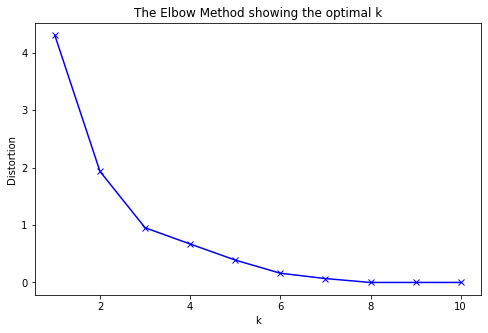

In [244]:
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The maximum change in slope appears to occur at a k-value of 3. So, we'll cluster the properties into 3 different clusters:

In [253]:
# Run k-means to cluster the properties into clusters
# set number of clusters
kclusters = 3

locations_clustering = locations_grouped.drop(['ID', 'Street'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(locations_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:len(locations_clustering)]

array([2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2],
      dtype=int32)

Let's create a new dataframe that includes the cluster number and the top 10 venues for each location:

In [255]:
# add clustering labels
locations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge dataframes to add latitude/longitude for each location
locations_merged = property_locations
locations_merged = locations_merged.join(locations_venues_sorted.drop('Street', 1).set_index('ID'), on='ID')

locations_merged.head()

,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2,Latitude,Longitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00,28.499342,-13.859905,...,Tapas Restaurant,Breakfast Spot,Coffee Shop,Clothing Store,Café,Pizza Place,Fast Food Restaurant,Gastropub,Bistro,Burger Joint
1,2,Gran Tarajal,Calle MAJUGA,122.0,3.0,3.0,165000,1352.46,28.210684,-14.030876,...,Restaurant,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint
2,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,126.0,3.0,2.0,155000,1230.16,28.730723,-13.865191,...,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
3,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,150000,1162.79,28.730723,-13.865191,...,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
4,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,124.0,3.0,2.0,150000,1209.68,28.730723,-13.865191,...,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant


Let's see how many properties we have in each cluster:

In [256]:
locations_merged['Cluster Labels'].value_counts()

2    16
1     3
0     1
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters on a map:

In [257]:
# create map
map_clusters = folium.Map(location=[28.3333, -14.0167], zoom_start=9)

# set colors
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(locations_merged['Latitude'], locations_merged['Longitude'], locations_merged['ID'],
                                  locations_merged['Cluster Labels']):
    label = folium.Popup('ID ' + str(poi) + ', Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining the Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

Based on the defining categories, we can then assign a name to each cluster.

##### Cluster 1:

In [258]:
cluster1 = locations_merged.loc[locations_merged['Cluster Labels'] == 0, 
                                locations_merged.columns[list(range(0, 3)) + list(range(11, locations_merged.shape[1]))]]
cluster1

,ID,Location,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,16,Caleta de Fuste,Calle Artemy,Resort,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint


##### Cluster 2:

In [259]:
cluster2 = locations_merged.loc[locations_merged['Cluster Labels'] == 1, 
                                locations_merged.columns[list(range(0, 3)) + list(range(11, locations_merged.shape[1]))]]
cluster2

,ID,Location,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2,Gran Tarajal,Calle MAJUGA,Restaurant,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint
5,6,Antigua,Calle Isla de La Graciosa,Restaurant,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint
12,13,Antigua,Calle Atalaya Park,Restaurant,Water Park,Business Service,Dessert Shop,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café,Burger Joint


##### Cluster 3:

In [260]:
cluster3 = locations_merged.loc[locations_merged['Cluster Labels'] == 2, 
                                locations_merged.columns[list(range(0, 3)) + list(range(11, locations_merged.shape[1]))]]
cluster3

,ID,Location,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Puerto del Rosario,CANDRAY 10,Tapas Restaurant,Breakfast Spot,Coffee Shop,Clothing Store,Café,Pizza Place,Fast Food Restaurant,Gastropub,Bistro,Burger Joint
2,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
3,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
4,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
6,7,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
7,8,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
8,9,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
9,10,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
10,11,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,Café,Hotel,Beach,Athletics & Sports,Bistro,Cocktail Bar,Hotel Bar,Pharmacy,Diner,Restaurant
11,12,Corralejo,Calle PARDELA,Hotel,Business Service,Golf Course,Restaurant,Water Park,Coffee Shop,Cocktail Bar,Clothing Store,Chinese Restaurant,Café


Cluster 3 appears to show the property listings with more diverse (and more interesting) venues to choose from.

Let's list again all properties within this cluster (this is our expected **Shortlist of Top Properties**):

In [262]:
top_properties_IDs = cluster3['ID'].tolist()
top_properties_IDs
top_properties = property_locations[property_locations['ID'].isin(top_properties_IDs)]
top_properties

,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2,Latitude,Longitude
0,1,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00,28.499342,-13.859905
2,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,126.0,3.0,2.0,155000,1230.16,28.730723,-13.865191
3,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,150000,1162.79,28.730723,-13.865191
4,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,124.0,3.0,2.0,150000,1209.68,28.730723,-13.865191
6,7,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,126500,1054.17,28.730723,-13.865191
7,8,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,125500,972.87,28.730723,-13.865191
8,9,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,137500,1145.83,28.730723,-13.865191
9,10,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,122.0,3.0,2.0,134500,1102.46,28.730723,-13.865191
10,11,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,134500,1120.83,28.730723,-13.865191
11,12,Corralejo,Calle PARDELA,120.0,3.0,2.0,158700,1322.50,28.710112,-13.874482


### Examining Clusters (Even More)

Let's now divide the previous cluster into smaller clusters, this time based on property data (i.e. number of rooms, bathrooms, size, price, etc.).

We'll use again the Elbow Method to determine the optimum number of clusters:

In [314]:
distortions = []
K = range(1,11)

locations_clustering = top_properties.drop(top_properties.columns[[0, 1, 2, 3]], axis = 1)
normalized_data=(locations_clustering-locations_clustering.min())/(locations_clustering.max()-locations_clustering.min())

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(locations_clustering)
    distortions.append(kmeanModel.inertia_)

Let's plot the results:

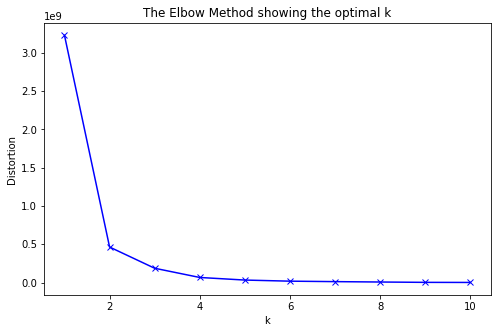

In [315]:
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The graph shows that the optimum k-value in this case is 2. We'll use this value to divide the property into this number of clusters:

In [305]:
# Run k-means to cluster the properties into clusters
# set number of clusters
kclusters = 2

top_properties_clustering = top_properties.drop(top_properties.columns[[0, 1, 2, 3]], axis = 1, inplace=False)
normalized_data=(top_properties_clustering-top_properties_clustering.min())/(top_properties_clustering.max()-top_properties_clustering.min())

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(normalized_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:len(top_properties)]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster numbers:

In [316]:
# add clustering labels
del top_properties['Cluster Labels']
top_properties.insert(0, 'Cluster Labels', kmeans.labels_)

top_properties

,Cluster Labels,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2,Latitude,Longitude
0,1,1,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00,28.499342,-13.859905
2,1,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,126.0,3.0,2.0,155000,1230.16,28.730723,-13.865191
3,1,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,150000,1162.79,28.730723,-13.865191
4,1,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,124.0,3.0,2.0,150000,1209.68,28.730723,-13.865191
6,0,7,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,126500,1054.17,28.730723,-13.865191
7,0,8,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,125500,972.87,28.730723,-13.865191
8,0,9,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,137500,1145.83,28.730723,-13.865191
9,0,10,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,122.0,3.0,2.0,134500,1102.46,28.730723,-13.865191
10,0,11,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,134500,1120.83,28.730723,-13.865191
11,1,12,Corralejo,Calle PARDELA,120.0,3.0,2.0,158700,1322.50,28.710112,-13.874482


Let's see how many properties are in each cluster:

In [317]:
top_properties['Cluster Labels'].value_counts()

1    9
0    7
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters on the map:

In [318]:
# create map
map_clusters = folium.Map(location=[28.3333, -14.0167], zoom_start=9)

# set colors
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(top_properties['Latitude'], top_properties['Longitude'], top_properties['ID'],
                                  top_properties['Cluster Labels']):
    label = folium.Popup('ID ' + str(poi) + ', Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, we can examine each cluster more in detail and determine the discriminating factors that distinguish each cluster.

Based on the defining categories, we can then assign a name to each cluster.

##### Cluster 1

In [319]:
cluster1 = top_properties.loc[top_properties['Cluster Labels'] == 0, 
                                top_properties.columns[list(range(1, 9))]]
cluster1

,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2
6,7,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,126500,1054.17
7,8,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,125500,972.87
8,9,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,137500,1145.83
9,10,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,122.0,3.0,2.0,134500,1102.46
10,11,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,134500,1120.83
16,17,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,120.0,3.0,2.0,127500,1062.50
18,19,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,122.0,3.0,2.0,129000,1057.38


##### Cluster 2:

In [320]:
cluster2 = top_properties.loc[top_properties['Cluster Labels'] == 1, 
                                top_properties.columns[list(range(1, 9))]]
cluster2

,ID,Location,Street,Size,Rooms,Bathrooms,Price,Price/m2
0,1,Puerto del Rosario,CANDRAY 10,125.0,3.0,2.0,165000,1320.00
2,3,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,126.0,3.0,2.0,155000,1230.16
3,4,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,129.0,3.0,2.0,150000,1162.79
4,5,Corralejo,Calle PARDELA URB.MIRADOR DE LAS DUNAS S/N,124.0,3.0,2.0,150000,1209.68
11,12,Corralejo,Calle PARDELA,120.0,3.0,2.0,158700,1322.50
13,14,Pajara,Calle Real,172.0,3.0,2.0,160103,930.83
14,15,Puerto del Rosario,Betoveen 110,145.0,4.0,3.0,162000,1117.24
17,18,Corralejo,el roque,140.0,3.0,2.0,165000,1178.57
19,20,Antigua,Maestro Leonardo,120.0,3.0,2.0,149000,1241.67


##### Cluster 1 vs. Cluster 2

Let's use boxplots from the Seaborn Library to see how the two clusters compare to each other with regards to price, price per square meter and size:

[Text(0, 0, '1'), Text(0, 0, '2')]

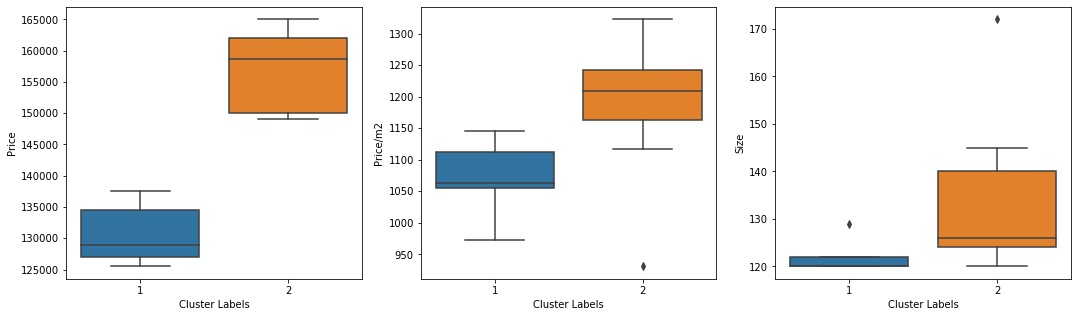

In [321]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
sns.boxplot(x='Cluster Labels', y='Price', data=top_properties, ax=ax[0])
sns.boxplot(x='Cluster Labels', y='Price/m2', data=top_properties, ax=ax[1])
sns.boxplot(x='Cluster Labels', y='Size', data=top_properties, ax=ax[2])
ax[0].set_xticklabels(['1', '2', '3'])
ax[1].set_xticklabels(['1', '2', '3'])
ax[2].set_xticklabels(['1', '2', '3'])

A Closer inspection of the properties within the two clusters show that:
 - Cluster 1 is made up solely of apartments that are in the same complex and are relatively smaller in size.
 - Cluster 2 is made up of single-family homes with a small garden.


## 3. Conclusion

In this project, we determined the island of the Canary Islands with "best" weather based on certain subjective criteria. Then we explored the real estate market on the island and narrowed down the options based on preferences regarding property characteristics (i.e. max. price, min. number of rooms, min. number of bathrooms and min. size) and availability of amenities and services.

As a result we obtained a **Shortlist of Top Properties**, which we then further divided into two smaller lists; one with apartments within a same complex and another one with single-family homes with a small garden. Based on this pre-selection, a potential retiree could plan his or her visits to the listed properties and make a final decision for buying a wonderful home for retirement.